In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train_dir="/kaggle/input/signature-verification-dataset/sign_data/train/"
train_csv="/kaggle/input/signature-verification-dataset/sign_data/train_data.csv"
test_dir="/kaggle/input/signature-verification-dataset/sign_data/test/"
test_csv="/kaggle/input/signature-verification-dataset/sign_data/test_data.csv"

In [3]:
df_train=pd.read_csv(train_csv)
df_train.head() #get first 5 rows.

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [4]:
df_test = pd.read_csv(test_csv)
df_test.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


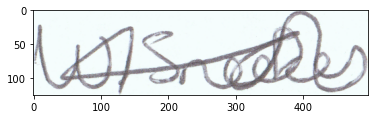

In [5]:
import matplotlib.pyplot as plt
img = plt.imread(train_dir+df_train.iat[1,0]) #1st row, 0th column
plt.imshow(img)

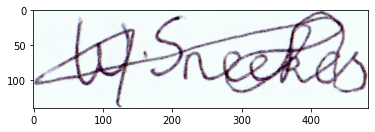

In [6]:
import matplotlib.pyplot as plt
img = plt.imread(train_dir+df_train.iat[1,1])
plt.imshow(img)

In [7]:
import cv2
test_images1 = [] #the genuine one.
test_images2 = [] #testing one. 

test_labels = []
for j in range(0,len(df_test)):
    img1 = cv2.imread(test_dir+df_test.iat[j,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    test_images1.append([img1])
    
    img2 = cv2.imread(test_dir+df_test.iat[j,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    test_images2.append([img2])
    
    test_labels.append(np.array(df_test.iat[j,2]))

test_images1 = np.array(test_images1)/255.0 #pixel value 0 to 255. divide by 255, we get in 0 to 1 range. fast for computation.
test_images2 = np.array(test_images2)/255.0
test_labels = np.array(test_labels)

In [8]:
import cv2

train_images1 = []
train_images2 = []
train_labels = []

for i in range(len(df_train)):
    img1 = cv2.imread(train_dir+df_train.iat[i,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    train_images1.append([img1])
    
    img2 = cv2.imread(train_dir+df_train.iat[i,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    train_images2.append([img2])
    
    train_labels.append(np.array(df_train.iat[i,2]))
    
train_images1 = np.array(train_images1)/255.0
train_images2 = np.array(train_images2)/255.0
train_labels = np.array(train_labels)

In [9]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [10]:
train_images1.shape

(23205, 1, 100, 100)

In [11]:
train_labels.shape

(23205, 2)

In [12]:
from sklearn.utils import shuffle
train_images1,train_images2,train_labels = shuffle(train_images1,train_images2,train_labels)
test_images1,test_images2,test_labels = shuffle(test_images1,test_images2,test_labels)

In [13]:
size = 100
train_images1 = train_images1.reshape(-1, size,size, 1) #to mention grey, added 1 in the end. {number of rows, height, width, numberof colors}
train_images2 = train_images2.reshape(-1, size,size, 1)
test_images1  = test_images1.reshape(-1, size,size, 1)
test_images2  = test_images2.reshape(-1, size,size, 1)

In [14]:
train_images1.shape

(23205, 100, 100, 1)

In [15]:
from keras import backend as K
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
input_dim = (100,100,1)

In [17]:
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [18]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    kernel_size = 3
    
    seq.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    
    seq.add(Convolution2D(32, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dense(64, activation='relu'))
    return seq

base_network = build_base_network(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(2,activation='sigmoid')(distance) #1 neuron, sigmoid shrinks distance between 0 and 1.

In [19]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3, #tolerates 3 times opposition
                              verbose=1) #shows in terminal

callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [20]:
model = Model([img_a, img_b],prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           2194272     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

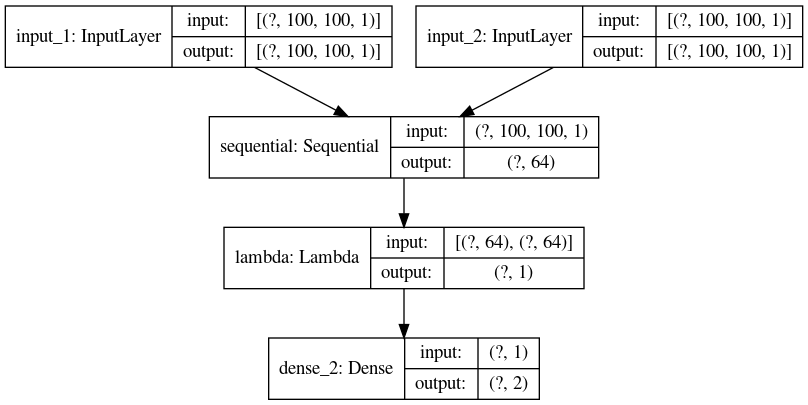

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00006)
              , metrics=["accuracy"])

In [26]:
history = model.fit([train_images1,train_images2], train_labels, validation_split=.30,
      batch_size= 32, verbose=1, epochs=20, callbacks=callback_early_stop_reduceLROnPlateau)

Epoch 1/20
508/508 [==============================] - 9s 18ms/step - loss: 0.3428 - accuracy: 0.9900 - val_loss: 0.3378 - val_accuracy: 0.9935
Epoch 2/20
508/508 [==============================] - 8s 16ms/step - loss: 0.3342 - accuracy: 0.9946 - val_loss: 0.3303 - val_accuracy: 0.9928
Epoch 3/20
508/508 [==============================] - 8s 16ms/step - loss: 0.3261 - accuracy: 0.9967 - val_loss: 0.3205 - val_accuracy: 0.9987
Epoch 4/20
508/508 [==============================] - 8s 16ms/step - loss: 0.3183 - accuracy: 0.9980 - val_loss: 0.3141 - val_accuracy: 0.9966
Epoch 5/20
508/508 [==============================] - 8s 17ms/step - loss: 0.3104 - accuracy: 0.9988 - val_loss: 0.3084 - val_accuracy: 0.9970
Epoch 6/20
508/508 [==============================] - 8s 16ms/step - loss: 0.3029 - accuracy: 0.9999 - val_loss: 0.2980 - val_accuracy: 1.0000
Epoch 7/20
508/508 [==============================] - 8s 16ms/step - loss: 0.2958 - accuracy: 0.9997 - val_loss: 0.2914 - val_accuracy: 1.0000

<Figure size 432x288 with 0 Axes>

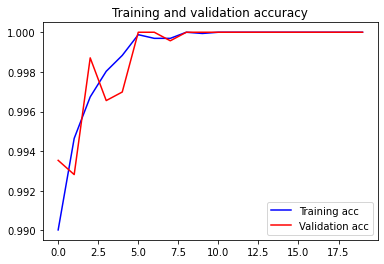

<Figure size 432x288 with 0 Axes>

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

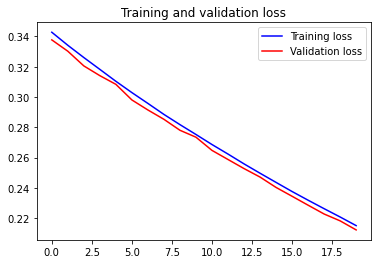

In [28]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [29]:
pred_y = model.predict([test_images1,test_images2])

In [30]:
test_labels = np.array(df_test['1'])

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_y.argmax(axis=1), test_labels)

0.5033930746476423